In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import os
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

data_folder = Path("../../data")

# Necessary for notebook to see src package
import sys
sys.path.append('../..')

Device: cuda


# Download Dataset into Memory

In [2]:
dataset = pd.read_csv(data_folder / 'Insurance' / 'data.csv')
dataset.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


# Missing Values

There is no missing values in CTABGAN+ datasets but i am just making sure

In [3]:
print(f'Missing values in the dataset: {dataset.isna().sum().sum()}')

Missing values in the dataset: 0


# General Info

- Column `education-num` had the same info as the `education` column so it was safe an beneficial to drop that column 
- We can see that the columns _workclass_, _education_, _marital-status_, _occupation_, _relationship_, _race_, _gender_, _native-country_, _income_ are categorical variables.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
string_columns = [col for col in dataset.columns if dataset[col].dtype == 'object']
other_columns = [col for col in dataset.columns if col not in string_columns]

print(f'String cols: {string_columns}')
print(f'Other cols: {other_columns}')

String cols: ['sex', 'smoker', 'region']
Other cols: ['age', 'bmi', 'children', 'charges']


# Categorical and Numerical Values

In [6]:
binary_columns = [col for col in other_columns if dataset[col].unique().__len__() <= 2]
multi_class_columns = [col for col in other_columns if (dataset[col].unique().__len__() > 2) and (dataset[col].unique().__len__() <= 10) ]
numeric_columns = [col for col in other_columns if col not in binary_columns and col not in multi_class_columns]

binary_columns = binary_columns + [col for col in string_columns if dataset[col].unique().__len__() <= 2]
multi_class_columns = multi_class_columns + [col for col in string_columns if (dataset[col].unique().__len__() > 2)]

print(f'binary_columns({len(binary_columns)}): {binary_columns}')
print(f'multi_class_columns({len(multi_class_columns)}): {multi_class_columns}')
print(f'numeric_columns({len(numeric_columns)}): {numeric_columns}')

binary_columns(2): ['sex', 'smoker']
multi_class_columns(2): ['children', 'region']
numeric_columns(3): ['age', 'bmi', 'charges']


# Other Columns and Their Cardinalities

In [7]:
for col in other_columns:
    print(f'{col:<20}: {dataset[col].dtype}({dataset[col].unique().__len__()})')

age                 : int64(47)
bmi                 : float64(548)
children            : int64(6)
charges             : float64(1337)


# Single Mode Gaussian Variables 

Here we can see that `age` is a single mode Gaussion variable

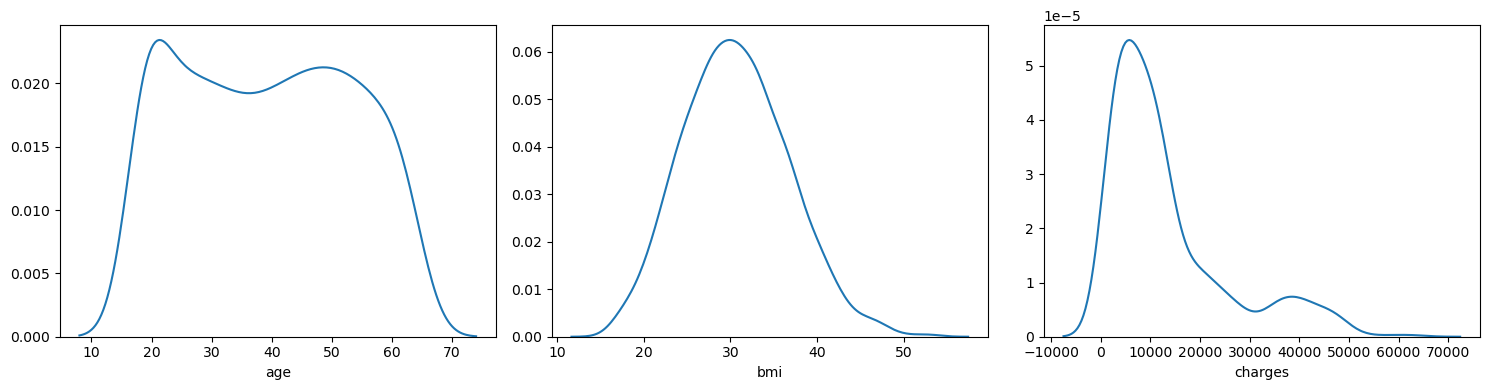

In [8]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(numeric_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(numeric_columns) / 3.0), ncols=3)

for col_index in range(len(numeric_columns)):
    current_ax: Axes = ax[col_index % 3]
    sns.kdeplot(
        data=dataset[numeric_columns[col_index]],
        ax=current_ax,
        common_norm=False,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Mixed Type Variables

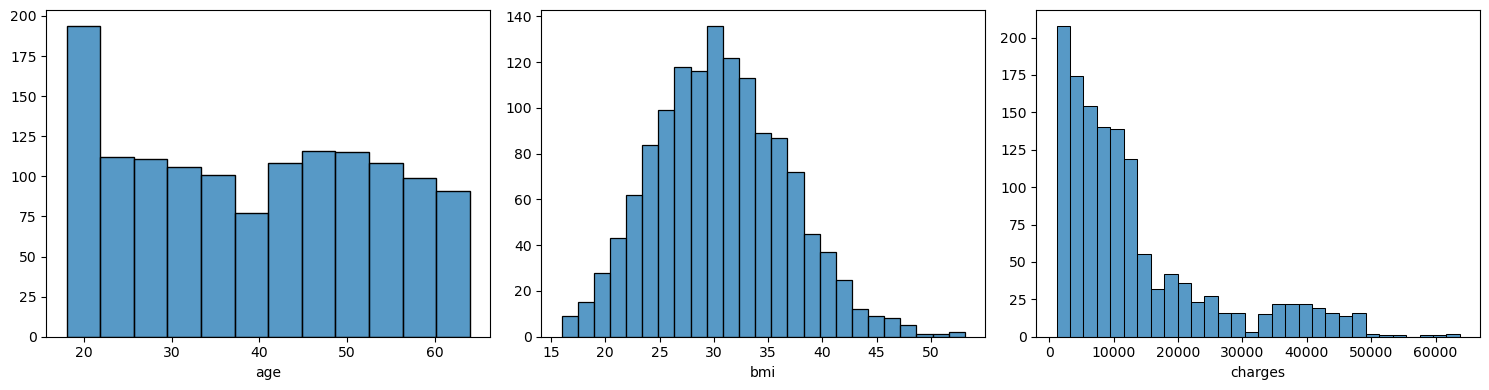

In [9]:
import math
from matplotlib.axes import Axes

fig = plt.figure(figsize=(15, math.ceil(len(numeric_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(numeric_columns) / 3.0), ncols=3)

for col_index in range(len(numeric_columns)):
    current_ax: Axes = ax[col_index % 3]
    sns.histplot(
        data=dataset[numeric_columns[col_index]],
        ax=current_ax,
    )
    current_ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Categorical Variables

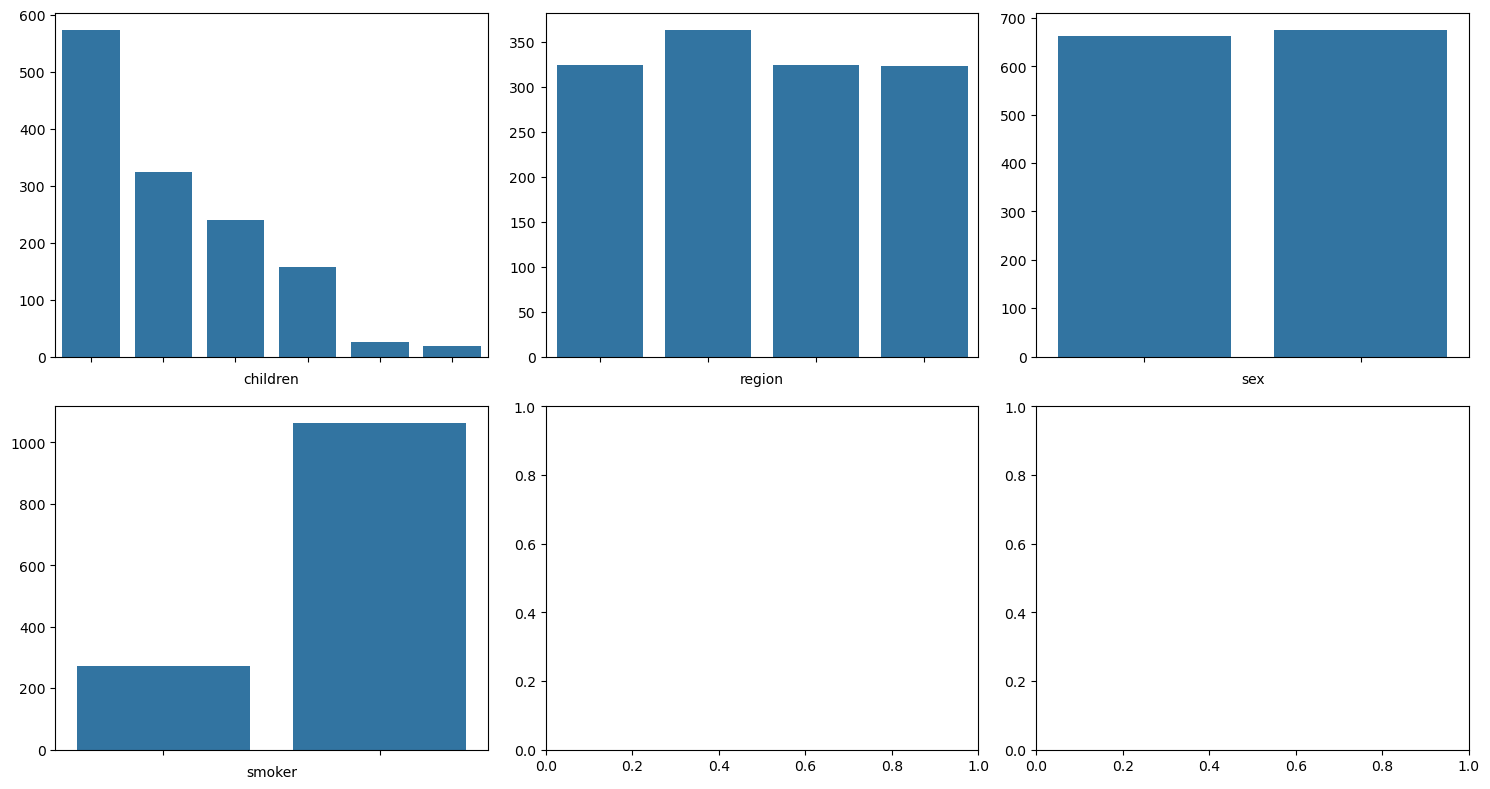

In [10]:
import math
from matplotlib.axes import Axes

categorical_columns = multi_class_columns + binary_columns

fig = plt.figure(figsize=(15, math.ceil(len(categorical_columns) / 3.0) * 4))
ax = fig.subplots(nrows=math.ceil(len(categorical_columns) / 3.0), ncols=3)

for col_index in range(len(categorical_columns)):
    current_ax: Axes = ax[math.floor(col_index / 3.0)][col_index % 3]
    sns.countplot(
        data=dataset,
        x=categorical_columns[col_index],
        ax=current_ax,
    )
    current_ax.set_ylabel('')
    current_ax.set_xticklabels([])
plt.tight_layout()
plt.show()

The final argumnets for the dataset is:

In [11]:
import json

args = {
    'categorical_columns' :categorical_columns,
    'log_columns': [],
    'mixed_columns': {}, # Mixed Types
    'general_columns': ['bmi'],                                 # Single Gaussian Mode or Highly cardinal data
    'non_categorical_columns': [],
    'integer_columns': [col for col in numeric_columns if dataset[col].dtype=='int'],
    'problem_type': 'regression',
    'target': 'charges'
}

with open(data_folder / 'Insurance' / 'metadata.json', 'w+') as file:
    json.dump(args, file, indent=4)

In [12]:
args

{'categorical_columns': ['children', 'region', 'sex', 'smoker'],
 'log_columns': [],
 'mixed_columns': {},
 'general_columns': ['bmi'],
 'non_categorical_columns': [],
 'integer_columns': ['age'],
 'problem_type': 'regression',
 'target': 'charges'}